## Importations

In [145]:
import pandas as pd
from pmdarima import auto_arima
from pmdarima.arima import ARIMA
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import SGDRegressor
import numpy as np
import matplotlib.pyplot as plt

SPLIT_DATASET = True # Use this if you want to perform tests on parts of the time series
DATASET_SPLIT_RATIO = 0.85 # If SPLIT_DATASET, is set to True, defines how much of the data should be used for training
FORECAST_LENGTH = 120 # Number of forecast samples to generate if SPLIT_DATASET is set to False


In [146]:
def make_stationary(time_series):
    """
    Make a time series stationary if the p-value computed using the ADF test is higher than 0.05
    """
    test_results = adfuller(time_series)
    p_value = test_results[1]
    if p_value > 0.05: # i.e. if the data is not stationary
        # Differentiating until the p-value goes under 0.05
        diff_data = time_series.copy()
        for degree in range(1, 10):
            diff_data = diff_data.diff().dropna()
            if adfuller(diff_data)[1] <= 0.05:
                return diff_data
        
        raise ValueError(f"Unable to stationarize data after diferentiating {degree} times")
    return time_series

def decompose_data(time_series):
    """
    Decompose our data following an additive model
    """
    additive_decomposition = seasonal_decompose(time_series.values, model='additive', period=12)
    return {
        "trend": additive_decomposition.trend,
        "seasonal": additive_decomposition.seasonal,
        "residual": additive_decomposition.resid
    }
        

## Chargement des données

In [160]:
data = pd.read_csv("./data/GlobalTemperatures.csv")
print(data.head())
# Getting rid of empty values (the first 1300 or so are missing)
temp = data["LandAndOceanAverageTemperature"].interpolate(limit_direction="backward")[1300:]
dates = pd.to_datetime(data["dt"])[1300:]

if SPLIT_DATASET:
    TRAINING_SAMPLES_COUNT = int(len(dates) * DATASET_SPLIT_RATIO)
    train, test = train_test_split(temp, train_size=TRAINING_SAMPLES_COUNT)
    train_dates, future_dates = train_test_split(dates, train_size=TRAINING_SAMPLES_COUNT)


else:
    train = temp
    train_dates = dates

# Making our series stationary
train_components = decompose_data(train)
detrended_train = train.values - train_components["trend"]
trend_train = pd.Series(train_components["trend"])
detrended_train = pd.Series(detrended_train).reset_index(drop=True)



AttributeError: 'DataFrame' object has no attribute 'summary'

## Recherche des meilleurs paramètres et entraînement

Paramètres du meilleur modèle :
Best model:  ARIMA(1,1,1)(2,0,2)[12] intercept

In [156]:
trend_train = trend_train.dropna()
print(np.array(trend_train.index).reshape(-1, 1))
print(np.array(trend_train.values))

#model = auto_arima(train, seasonal=True, m=12, trace=True)
#print(str(model.summary()))
model = ARIMA(order=(1, 1, 1), seasonal_order=(2, 0, 2, 12))
model.fit(detrended_train)

# ENTRAÎNER UN MODÈLE DE RÉGRESSION SUR LA TENDANCE ICI :
trend_model = SGDRegressor()
trend_model.fit(np.array(trend_train.index).reshape(-1, 1), trend_train.interpolate().values)


[[   6]
 [   7]
 [   8]
 ...
 [1599]
 [1600]
 [1601]]
[14.90904167 14.93216667 14.941      ... 15.60566667 15.60825
 15.60308333]


SGDRegressor()

## Prédiction

In [158]:
if SPLIT_DATASET:
    detrended_forecasts = model.predict(len(test))  # predict N steps into the future
    future_index = np.arange(trend_train.index[-1]+1, trend_train.index[-1]+1 + len(test)).reshape(-1, 1)
    trend_forecasts = trend_model.predict(future_index)

    forecasts = detrended_forecasts + trend_forecasts
    print(forecasts)
else:
    forecasts = model.predict(FORECAST_LENGTH)  # predict 10 years into the future

forecasts = pd.Series(forecasts)

1608    8.385640e+13
1609    8.390871e+13
1610    8.396102e+13
1611    8.401333e+13
1612    8.406564e+13
            ...     
1887    9.845088e+13
1888    9.850319e+13
1889    9.855550e+13
1890    9.860781e+13
1891    9.866012e+13
Length: 284, dtype: float64


## Visualisation

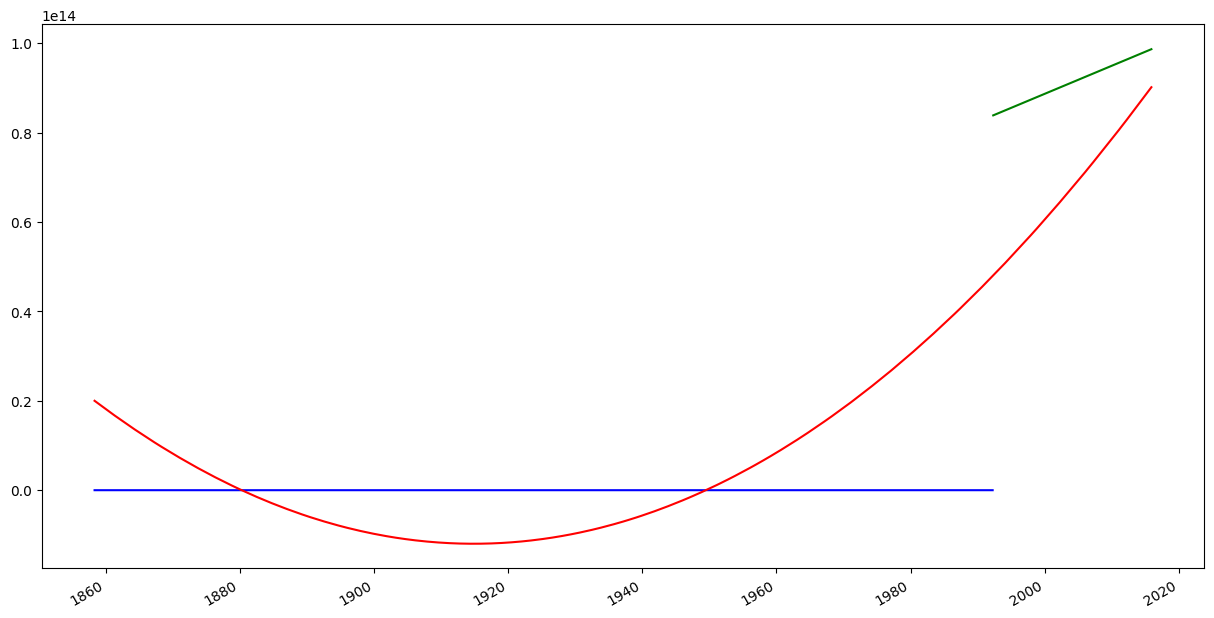

In [159]:
# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize=(15,8))


if SPLIT_DATASET:
    x = np.arange(len(train) + len(forecasts))
    trend = np.polyfit(x, pd.concat([train, forecasts]), 2)

else:
    # Generating extra dates for the forecast
    start_date = dates.iloc[-1] + pd.DateOffset(months=1)
    future_dates = pd.date_range(start_date, periods=FORECAST_LENGTH, freq="M").to_series()
    all_dates = pd.concat([dates, future_dates])
    x = np.arange(len(train) + len(forecasts))
    trend = np.polyfit(x, pd.concat([train, forecasts]), 2)




trendpoly = np.poly1d(trend)
plt.plot(train_dates, train, c='blue')
plt.plot(future_dates, forecasts, c='green')
plt.plot(all_dates, trendpoly(x), c="red")
plt.gcf().autofmt_xdate()
plt.show()

1892
1608
284
1892
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1887    0.007205
1888    0.691547
1889    1.231055
1890    1.473897
1891    1.416328
Name: 0, Length: 1892, dtype: float64
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1887   NaN
1888   NaN
1889   NaN
1890   NaN
1891   NaN
Length: 1892, dtype: float64
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
       ...  
95    14.713
96    15.630
97    16.596
98    17.060
99    16.695
Length: 100, dtype: float64
(3192, 2)


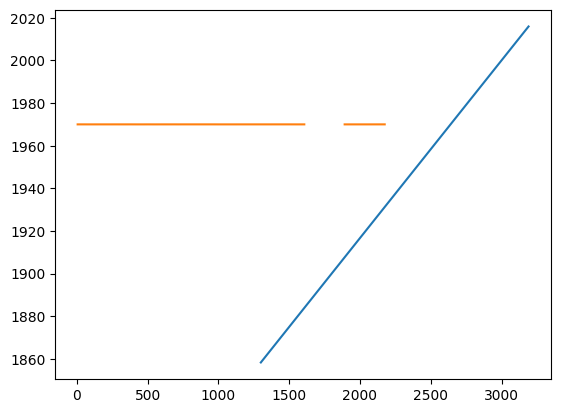

In [135]:
# Reintegrating trends + comparing forecasts to actual values

if SPLIT_DATASET:

    trend_data = pd.Series(components["trend"])
    all_temp = pd.concat([train, forecasts]).reset_index().drop(columns="index")[0]

    full_data = all_temp + trend_data


detrended_data = {
    "date": all_dates,
    "detrended_temp": pd.concat([train, forecasts])
}

detrended_df = pd.DataFrame(detrended_data)
print(detrended_df.shape)
plt.plot(detrended_df)


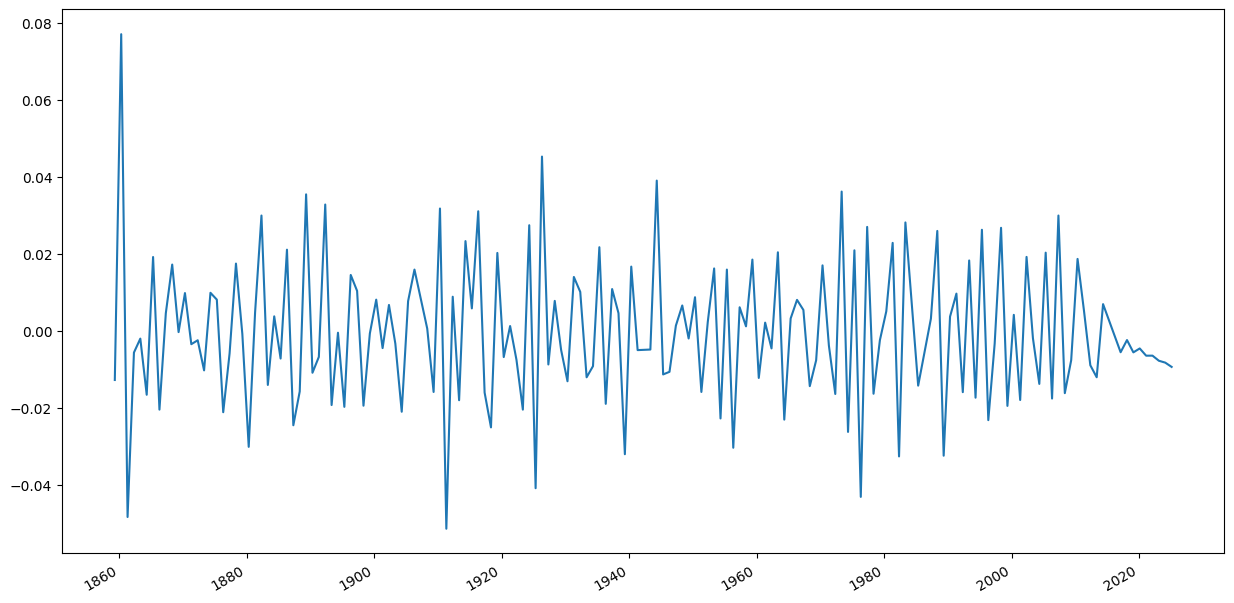

In [88]:
# Visualisation en faisant des moyennes de température annuelles, pour plus de visibilité
plt.figure(figsize=(15,8))

train.index = train_dates
yearly_train = train.rolling(window=12, step=12, center=True).mean().dropna()

forecasts.index = future_dates
yearly_forecasts = forecasts.rolling(window=12, step=12, center=True).mean().dropna()

all_data = pd.concat([yearly_train, yearly_forecasts])
x = np.arange(len(all_data))

plt.plot(all_data)
plt.gcf().autofmt_xdate()

